## 1. Introduction & Objective

Ths project builds a Grammar Scoring Engine that evaluates grammar proficiency from spoken audio samples.
Each audio is 45-60 seconds long and labeled with a Grammar Score (0 to 5) based on MOS Likert Scale.

In [2]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import language_tool_python
import whisper
import textstat
from xgboost import XGBRegressor

In [3]:
pwd

'C:\\Users\\anves\\Desktop\\shl\\dataset'

## 2. Dataset Overview
Load the dataset to colab

In [4]:
train_df = pd.read_csv("C:/Users/anves/Desktop/shl/dataset/train.csv") 
test_df = pd.read_csv("C:/Users/anves/Desktop/shl/dataset/test.csv")

print("Train shape:", train_df.shape)
print(train_df.head())

Train shape: (444, 2)
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0


### Audio Preprocessing

In [5]:
def load_audio(path, sr=16000):
    y, _ = librosa.load(path, sr=sr)
    return y

# Example load
print("Available columns:", train_df.columns)
sample_filename = train_df.columns[0] if 'file_name' not in train_df.columns else 'file_name'
audio_path = os.path.join("C:/Users/anves/Desktop/shl/dataset/audios_train", train_df[sample_filename].iloc[0])
audio_data = load_audio(audio_path)

Available columns: Index(['filename', 'label'], dtype='object')


### Transcription (Whisper)

In [6]:
whisper_model = whisper.load_model("base")

def transcribe_audio(path):
    result = whisper_model.transcribe(path)
    return result['text']


###Grammar Error Detection

In [7]:
tool = language_tool_python.LanguageTool('en-US')

def grammar_error_count(text):
    matches = tool.check(text)
    return len(matches)


### Feature Extraction

In [8]:
def extract_features(audio_path):
    transcript = transcribe_audio(audio_path)
    num_errors = grammar_error_count(transcript)
    audio, _ = librosa.load(audio_path, sr=16000)

    # Audio features
    mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)

    # Linguistic features
    num_words = len(transcript.split())
    num_sentences = transcript.count('.') + transcript.count('!') + transcript.count('?')
    avg_sentence_length = num_words / num_sentences if num_sentences > 0 else num_words
    readability = textstat.flesch_reading_ease(transcript)

    features = list(mfcc_mean) + [
        num_errors,
        num_words,
        num_sentences,
        avg_sentence_length,
        readability
    ]
    return features

# Example
sample_features = extract_features(audio_path)
print("Feature vector length:", len(sample_features))


C:\Users\anves\AppData\Local\Programs\Python\Python310\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Feature vector length: 18


# Prepare Dataset for Model
rate - ~250 items per hour plan accordingly

In [9]:
X = [] 
y = []

In [10]:
# Only use first 100 samples 
count=0
#for idx, row in train_df.iloc[:100].iterrows():
for idx, row in train_df.iterrows():
    print(count)
    count = count+1
    audio_path = os.path.join("C:/Users/anves/Desktop/shl/dataset/audios_train", row[sample_filename])
    features = extract_features(audio_path)
    X.append(features)
    y.append(row["label"])

X = np.array(X)
y = np.array(y)


0


C:\Users\anves\AppData\Local\Programs\Python\Python310\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


### Train-Test Split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## TRAIN MODEL

In [12]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

##Evaluation

In [13]:
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
pearson_corr, _ = pearsonr(y_val, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("Pearson Correlation:", pearson_corr)

MSE: 1.1771184190806414
MAE: 0.9390720838911077
Pearson Correlation: 0.3849079578294412


Visualization

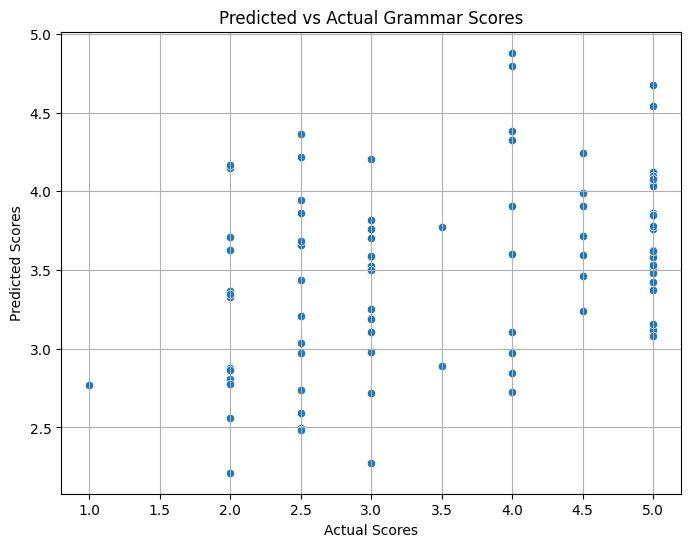

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("Actual Scores")
plt.ylabel("Predicted Scores")
plt.title("Predicted vs Actual Grammar Scores")
plt.grid(True)
plt.show()

#Predict on Test Set

In [17]:
submission = pd.read_csv("C:/Users/anves/Desktop/shl/dataset/sample_submission.csv")

predictions = []
count =0

for filename in test_df["filename"]:
    print(count)
    count = count+1
    audio_path = os.path.join("C:/Users/anves/Desktop/shl/dataset/audios_test/", filename)
    features = extract_features(audio_path)
    pred = model.predict([features])[0]
    predictions.append(pred)

submission["label"] = predictions
submission.to_csv("submission.csv", index=False)

0


C:\Users\anves\AppData\Local\Programs\Python\Python310\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


In [18]:
import joblib
joblib.dump(model, "grammar_score_model_RandomForestRegressor.pkl")
from IPython.display import FileLink
FileLink("grammar_score_model_RandomForestRegressor.pkl")

C:\Users\anves\Desktop\shl\dataset\grammar_score_model_RandomForestRegressor.pkl

# ============================
# 14. Conclusion
# ============================


In this notebook, we built a baseline Grammar Scoring Engine using audio and linguistic features.
Future improvements may include deep learning models (e.g., BERT + CNN) and data augmentation.
